# Reproducing AGBD estimates from GEDI L2A RH metrics
This tutorial shows how to reconstruct L4A aboveground biomass density (AGBD) estimates using L2A relative height (RH) metrics. We will use a GEDI L4A file `GEDI04_A_2020207182449_O09168_03_T03028_02_002_01_V002.h5` and corresponding GEDI L2A file `GEDI02_A_2020207182449_O09168_03_T03028_02_003_01_V002.h5` for this purpose.

In [1]:
# import all the modules
from os import path
import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

Let's open the L4A file, and read model parameters into a pandas dataframe

In [2]:
# GEDI L4a file
l4a = 'GEDI04_A_2020207182449_O09168_03_T03028_02_002_01_V002.h5'
l4af = path.join('full_orbits', l4a)
# read the L4A file
hf_l4a = h5py.File(l4af, 'r')

# model_parameters
model_data=hf_l4a['ANCILLARY']['model_data']
predict_stratum = model_data['predict_stratum'].astype('U13')
bias_correction_name = model_data['bias_correction_name'].astype('U13')
bias_correction_value = model_data['bias_correction_value']
x_transform = model_data['x_transform'].astype('U13')
y_transform = model_data['y_transform'].astype('U13')
npar = model_data['npar']
par = model_data['par']
rh_index = model_data['rh_index']

# pandas dataframe
df_l4a_model = pd.DataFrame(list(zip(predict_stratum, bias_correction_name, bias_correction_value,
                                    x_transform,y_transform, npar, par, rh_index)), 
                     columns=['predict_stratum', 'bias_correction_name', 'bias_correction_value',
                                    'x_transform', 'y_transform', 'npar', 'par', 'rh_index'])
df_l4a_model.set_index('predict_stratum', inplace=True)

# print the header rows
df_l4a_model.head()

,bias_correction_name,bias_correction_value,x_transform,y_transform,npar,par,rh_index
predict_stratum,,,,,,,
DBT_Af,Snowdon,1.092463,sqrt,sqrt,3,"[-118.40806579589844, 1.956794023513794, 9.961...","[50, 98, 0, 0, 0, 0, 0, 0]"
DBT_Au,Snowdon,1.017920,sqrt,sqrt,3,"[-155.41419982910156, 7.816701889038086, 7.709...","[70, 98, 0, 0, 0, 0, 0, 0]"
DBT_Eu,Snowdon,0.962632,sqrt,sqrt,3,"[-96.53070068359375, 7.175395488739014, 2.9214...","[70, 98, 0, 0, 0, 0, 0, 0]"
DBT_NAs,Snowdon,1.016632,sqrt,sqrt,3,"[-110.05912780761719, 5.133802890777588, 6.171...","[60, 98, 0, 0, 0, 0, 0, 0]"
DBT_SA,Snowdon,1.105528,sqrt,sqrt,3,"[-134.77015686035156, 6.653591632843018, 6.687...","[50, 98, 0, 0, 0, 0, 0, 0]"


Read the data from 'BEAM0110' into the pandas dataframe 'df_l4a'

In [3]:
shot_number_l4a = hf_l4a['BEAM0110']['shot_number'] # selected algorithm
agbd_l4a = hf_l4a['BEAM0110']['agbd'] # l4a agbd
selected_algorithm_l4a = hf_l4a['BEAM0110']['selected_algorithm'] # selected algorithm
predict_stratum = hf_l4a['BEAM0110']['predict_stratum'] # selected algorithm

df_l4a = pd.DataFrame(list(zip(shot_number_l4a[:], agbd_l4a[:], selected_algorithm_l4a[:], 
                               predict_stratum[:].astype('U13'))), 
                     columns=['shot_number_l4a', 'agbd_l4a', 'selected_algorithm_l4a', 'predict_stratum'])
df_l4a['shot_number_l4a'] = df_l4a['shot_number_l4a'].astype(str).str[-8:]
df_l4a = df_l4a.set_index('shot_number_l4a')

df_l4a.head()

,agbd_l4a,selected_algorithm_l4a,predict_stratum
shot_number_l4a,,,
00475310,-9999.000000,2,ENT_Eu
00475311,25.602335,1,ENT_Eu
00475312,24.043011,1,ENT_Eu
00475313,-9999.000000,2,ENT_Eu
00475314,-9999.000000,1,ENT_Eu


Now, plot the prediction strata

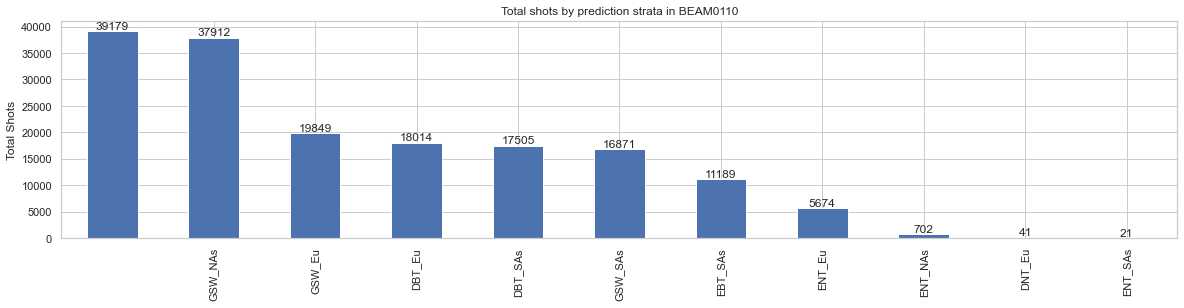

In [4]:
ax = df_l4a.predict_stratum.value_counts().plot(kind='bar',  ylabel='Total Shots', figsize=(20, 4))
ax.set_title(f'Total shots by prediction strata in BEAM0110')

ax.bar_label(ax.containers[0])
plt.show()

There are 10 predict strata for the beam. Let's also plot the selected algorithm setting groups.

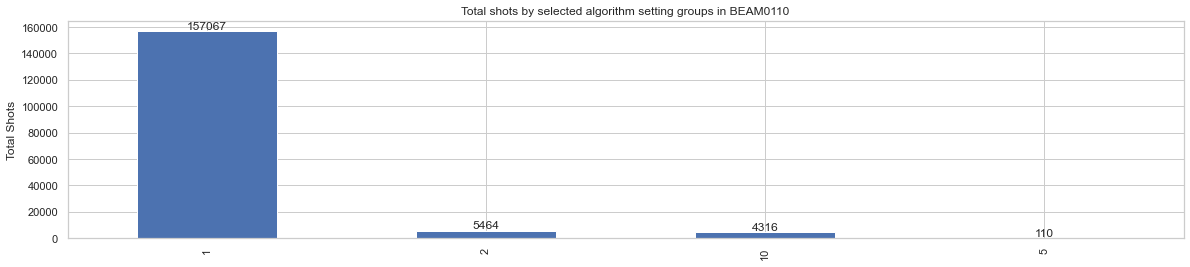

In [5]:
ax = df_l4a.selected_algorithm_l4a.value_counts().plot(kind='bar', ylabel='Total Shots', figsize=(20, 4))
ax.set_title(f'Total shots by selected algorithm setting groups in BEAM0110')
ax.bar_label(ax.containers[0])
plt.show()

There are a total of 4 algorithm setting groups selected for the beam.

Now, open the corresponding GEDI L2A file.

In [6]:
# GEDI L2a file
l2a = 'GEDI02_A_2020207182449_O09168_03_T03028_02_003_01_V002.h5'
l2af = path.join('full_orbits', l2a)

hf_l2a = h5py.File(l2af, 'r')

shot_number_l2a = hf_l2a['BEAM0110']['shot_number'][:]
selected_algorithm_l2a = hf_l2a['BEAM0110']['selected_algorithm'][:]

# selected_algorithm for a shot may be different for L2A and L4A
# it is always advisable to get the RH metrics directly for each 
# algorithm setting groups.

rh_a1 = hf_l2a['BEAM0110']['geolocation']['rh_a1'][:]/100
rh_a2 = hf_l2a['BEAM0110']['geolocation']['rh_a2'][:]/100
rh_a3 = hf_l2a['BEAM0110']['geolocation']['rh_a3'][:]/100
rh_a4 = hf_l2a['BEAM0110']['geolocation']['rh_a4'][:]/100
rh_a5 = hf_l2a['BEAM0110']['geolocation']['rh_a5'][:]/100
rh_a6 = hf_l2a['BEAM0110']['geolocation']['rh_a6'][:]/100

# Algorithm setting group 10 indicates that agorithm setting 5 
# has been used but that the lowest detected mode in this
# algorithm is likely a noise detection and that a higher mode 
# has been subsequently used to calculate the metrics. 
# Please refer to Level 2A user guide for details
# https://lpdaac.usgs.gov/documents/998/GEDI02_UserGuide_V21.pdf
selected_mode = hf_l4a['BEAM0110']['selected_mode'][:] # using L4A selected_mode
elevs_allmodes_a5 = hf_l2a['BEAM0110']['geolocation']['elevs_allmodes_a5'][:]
elev_lowestmode_a5 = hf_l2a['BEAM0110']['geolocation']['elev_lowestmode_a5'][:]
elev_lowestmode =[]
for i in range(selected_mode.shape[0]):
    elev_lowestmode.append(elevs_allmodes_a5[i, selected_mode[i]])
elev_lowestmode = np.array(elev_lowestmode)
rh_a10 = rh_a5 - (elev_lowestmode[:, None] - elev_lowestmode_a5[:, None])

df_l2a = pd.DataFrame(list(zip(shot_number_l2a, rh_a1, rh_a2, rh_a3, rh_a4, rh_a5, rh_a6, rh_a10, 
                               selected_algorithm_l2a)), 
                     columns=['shot_number_l2a', 'rh_a1', 'rh_a2', 'rh_a3', 'rh_a4', 'rh_a5', 'rh_a6', 'rh_a10', 
                              'selected_algorithm_l2a'])
df_l2a['shot_number_l2a'] = df_l2a['shot_number_l2a'].astype(str).str[-8:]
df_l2a.set_index('shot_number_l2a', inplace=True)
df_l2a.head()

,rh_a1,rh_a2,rh_a3,rh_a4,rh_a5,rh_a6,rh_a10,selected_algorithm_l2a
shot_number_l2a,,,,,,,,
00475310,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.08, -1.04, -1.0, -0.97, -0.93, -0.89, -0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.75, -1.68, -1.6, -1.53, -1.45, -1.38, -1.3...","[-0.33, -0.33, -0.29, -0.29, -0.26, -0.22, -0....","[-4.177726745605469, -4.1077267456054685, -4.0...",2
00475311,"[-1.19, -1.15, -1.12, -1.08, -1.04, -1.04, -1....","[-2.35, -2.27, -2.16, -2.09, -2.01, -1.94, -1....","[-1.26, -1.23, -1.19, -1.15, -1.15, -1.12, -1....","[-1.19, -1.19, -1.15, -1.12, -1.08, -1.08, -1....","[-2.87, -2.68, -2.53, -2.39, -2.27, -2.16, -2....","[-1.97, -1.94, -1.86, -1.79, -1.75, -1.68, -1....","[-2.87, -2.68, -2.53, -2.39, -2.27, -2.16, -2....",1
00475312,"[-0.97, -0.97, -0.93, -0.89, -0.85, -0.85, -0....","[-2.46, -2.39, -2.31, -2.24, -2.16, -2.09, -2....","[-1.19, -1.19, -1.15, -1.12, -1.08, -1.08, -1....","[-0.97, -0.97, -0.93, -0.93, -0.89, -0.89, -0....","[-3.06, -2.95, -2.8, -2.68, -2.57, -2.46, -2.3...","[-2.01, -1.97, -1.9, -1.86, -1.83, -1.75, -1.7...","[-3.06, -2.95, -2.8, -2.68, -2.57, -2.46, -2.3...",1
00475313,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.34, -1.3, -1.26, -1.23, -1.19, -1.15, -1.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.33, -0.29, -0.22, -0.18, -0.11, -0.03, 0.0...","[-0.18, -0.18, -0.18, -0.14, -0.14, -0.14, -0....","[-3.1685696411132813, -3.1285696411132813, -3....",2
00475314,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[158.7861328125, 158.7861328125, 158.786132812...",1


Join the L4A dataframe ('df_l4a') with the L2A dataframe ('df_2a').

In [7]:
df_l4a = df_l4a.join(df_l2a)
df_l4a = df_l4a[df_l4a.agbd_l4a != -9999] # removing Nan L4A agbd values
df_l4a.head()

,agbd_l4a,selected_algorithm_l4a,predict_stratum,rh_a1,rh_a2,rh_a3,rh_a4,rh_a5,rh_a6,rh_a10,selected_algorithm_l2a
shot_number_l4a,,,,,,,,,,,
00475311,25.602335,1,ENT_Eu,"[-1.19, -1.15, -1.12, -1.08, -1.04, -1.04, -1....","[-2.35, -2.27, -2.16, -2.09, -2.01, -1.94, -1....","[-1.26, -1.23, -1.19, -1.15, -1.15, -1.12, -1....","[-1.19, -1.19, -1.15, -1.12, -1.08, -1.08, -1....","[-2.87, -2.68, -2.53, -2.39, -2.27, -2.16, -2....","[-1.97, -1.94, -1.86, -1.79, -1.75, -1.68, -1....","[-2.87, -2.68, -2.53, -2.39, -2.27, -2.16, -2....",1
00475312,24.043011,1,ENT_Eu,"[-0.97, -0.97, -0.93, -0.89, -0.85, -0.85, -0....","[-2.46, -2.39, -2.31, -2.24, -2.16, -2.09, -2....","[-1.19, -1.19, -1.15, -1.12, -1.08, -1.08, -1....","[-0.97, -0.97, -0.93, -0.93, -0.89, -0.89, -0....","[-3.06, -2.95, -2.8, -2.68, -2.57, -2.46, -2.3...","[-2.01, -1.97, -1.9, -1.86, -1.83, -1.75, -1.7...","[-3.06, -2.95, -2.8, -2.68, -2.57, -2.46, -2.3...",1
00475317,24.283388,1,ENT_Eu,"[-1.94, -1.9, -1.83, -1.79, -1.75, -1.68, -1.6...","[-3.13, -3.02, -2.87, -2.76, -2.65, -2.57, -2....","[-2.24, -2.2, -2.12, -2.09, -2.01, -1.97, -1.9...","[-1.94, -1.9, -1.86, -1.79, -1.75, -1.71, -1.6...","[-3.54, -3.36, -3.17, -3.02, -2.87, -2.76, -2....","[-2.8, -2.72, -2.61, -2.53, -2.46, -2.35, -2.3...","[-3.54, -3.36, -3.17, -3.02, -2.87, -2.76, -2....",1
00475318,23.047647,2,ENT_Eu,"[-0.14, -0.14, -0.14, -0.11, -0.11, -0.07, -0....","[-2.2, -2.16, -2.09, -2.01, -1.97, -1.9, -1.86...","[-0.07, -0.07, -0.07, -0.03, -0.03, 0.0, 0.0, ...","[-0.14, -0.14, -0.14, -0.14, -0.14, -0.14, -0....","[-3.06, -2.95, -2.83, -2.72, -2.61, -2.5, -2.4...","[-1.56, -1.53, -1.49, -1.45, -1.38, -1.34, -1....","[-3.06, -2.95, -2.83, -2.72, -2.61, -2.5, -2.4...",2
00475320,23.937260,1,ENT_Eu,"[-0.59, -0.59, -0.56, -0.56, -0.52, -0.52, -0....","[-2.65, -2.57, -2.53, -2.46, -2.39, -2.31, -2....","[-0.85, -0.85, -0.82, -0.82, -0.78, -0.78, -0....","[-0.59, -0.59, -0.59, -0.59, -0.56, -0.56, -0....","[-3.36, -3.24, -3.13, -3.06, -2.95, -2.87, -2....","[-2.05, -2.01, -1.97, -1.9, -1.86, -1.83, -1.7...","[-3.36, -3.24, -3.13, -3.06, -2.95, -2.87, -2....",1


Let's calculate AGBD values from L2A RH metrics and save it to a new column 'agbd_l2a' in the dataframe.

In [8]:
def calculate_agbd(ps, sag, rh1, rh2, rh3, rh4, rh5, rh6, rh10):
    shot_model = df_l4a_model.loc[ps]
    agbd_t_l2a = shot_model['par'][0] # intercept
    for i in range(shot_model['npar']-1):
        r = shot_model['rh_index'][i]
        if (sag == 1):
            rh = rh1
        elif (sag == 2):
            rh = rh2
        elif (sag == 3):
            rh = rh3
        elif (sag == 4):
            rh = rh4
        elif (sag == 5):
            rh = rh5
        elif (sag == 6):
            rh = rh6
        elif (sag == 10):
            rh = rh10
            
        xvar_x = np.sqrt(rh[r] + predictor_offset)
        agbd_t_l2a += shot_model['par'][i+1] * xvar_x

    return (agbd_t_l2a**2) * shot_model['bias_correction_value']

predictor_offset = hf_l4a['BEAM0110']['agbd_prediction'].attrs['predictor_offset']
df_l4a['agbd_l2a']= df_l4a.apply(lambda x: calculate_agbd(x['predict_stratum'], x['selected_algorithm_l4a'],
                                                          x['rh_a1'], x['rh_a2'], x['rh_a3'], x['rh_a4'],
                                                          x['rh_a5'], x['rh_a6'], x['rh_a10'] ), axis=1)


Plot the L4A AGBD values against the AGBD derived from L2A RH metrics by the algorithm setting groups, and by the predict_stratum.

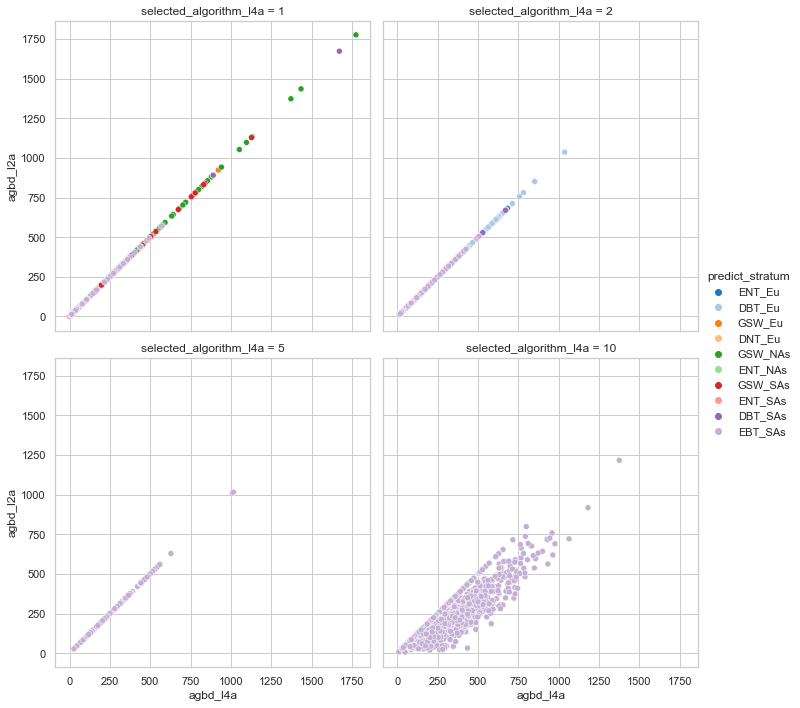

In [9]:
sns.relplot(data=df_l4a, x="agbd_l4a", y="agbd_l2a", hue="predict_stratum", 
                col="selected_algorithm_l4a", col_wrap=2,  palette="tab20")
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)


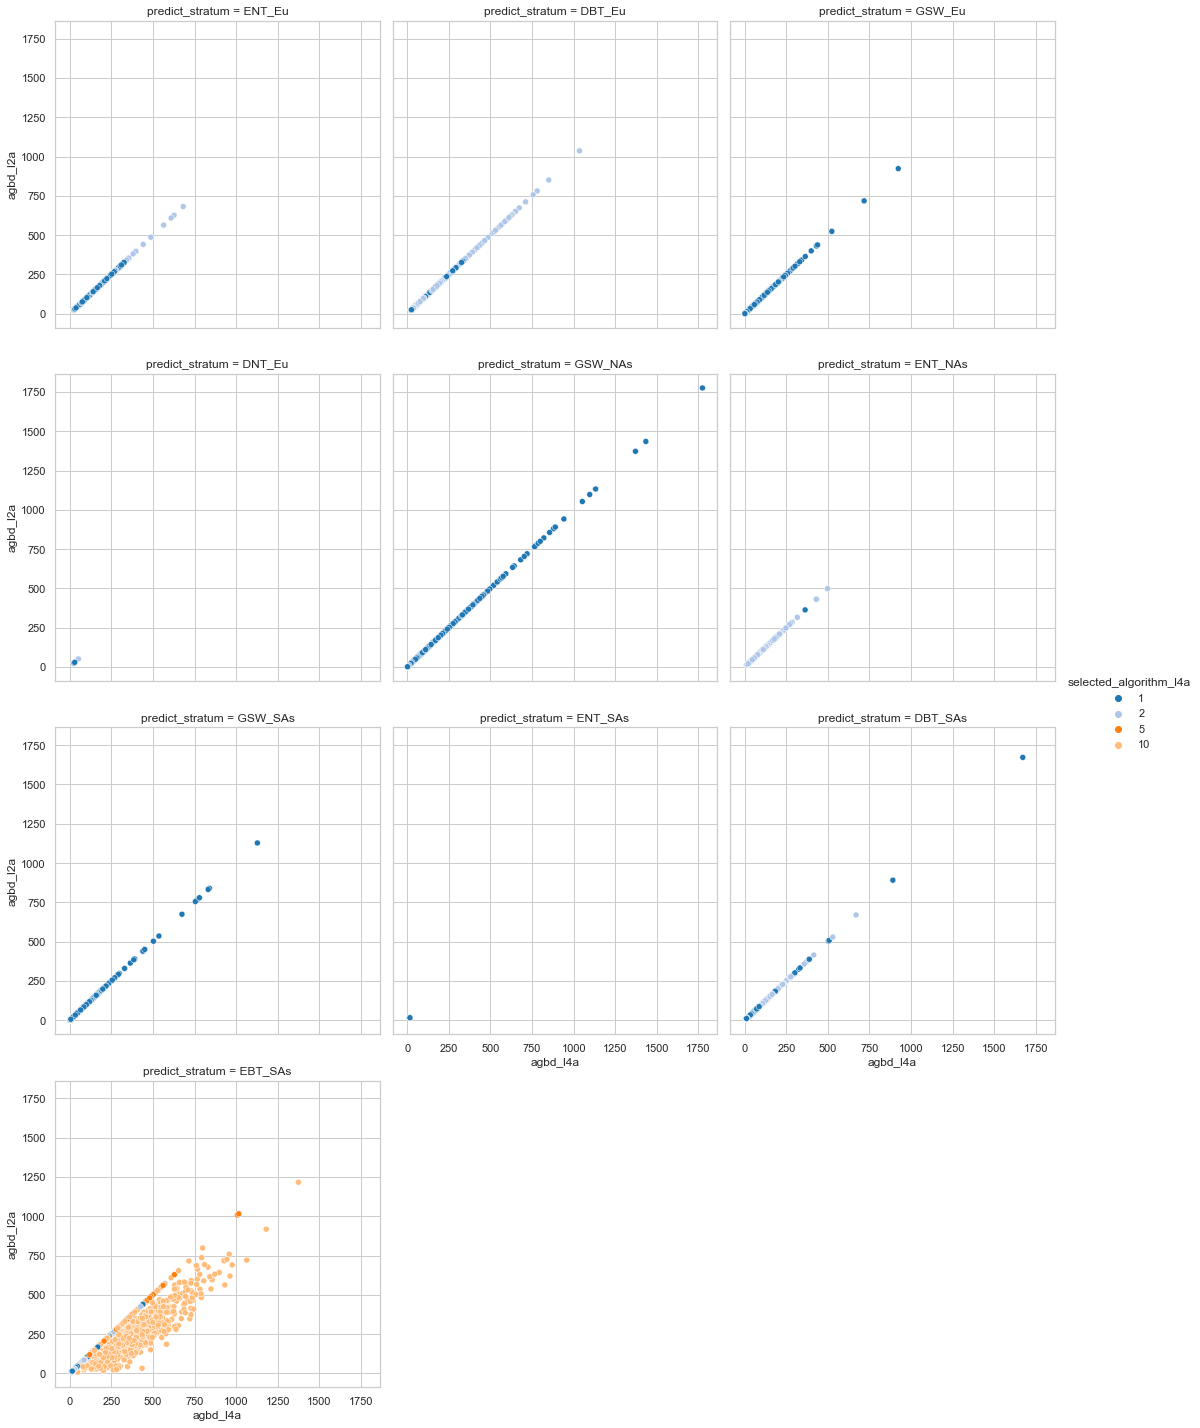

In [10]:
sns.relplot(data=df_l4a, x="agbd_l4a", y="agbd_l2a", hue="selected_algorithm_l4a", 
                col="predict_stratum", col_wrap=3,   palette="tab20")
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)